<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q1_folder/ML_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Question 1: Traditional Machine Learning Approach
Predicting GAD_T, SWL_T, and SPIN_T from Online Gaming Anxiety Data

 **Dataset:** Online Gaming Anxiety Data from Kaggle


Introduction
 This notebook explores traditional (non-neural network) machine learning approaches for predicting three psychological metrics from online gaming data:
 1. **GAD_T**: Generalized Anxiety Disorder score
 2. **SWL_T**: Satisfaction With Life score  
 3. **SPIN_T**: Social Phobia Inventory score

We'll compare multiple traditional ML algorithms to establish a performance baseline before moving to neural networks in Q2.

Objectives
 - Load and explore the gaming anxiety dataset
 - Preprocess data for machine learning
 - Implement and compare traditional ML models
 - Evaluate model performance using appropriate metrics
 - Interpret results and draw conclusions


In [12]:
# Import necessary libraries
import sys
import os

# Add parent directory to path to import our functions
# This line ensures Python can find our custom 'functions.py' file.
sys.path.append('..')

import numpy as np # Used for numerical operations, especially with arrays.
import pandas as pd # Essential for data manipulation and analysis, especially with DataFrames.
import matplotlib.pyplot as plt # Used for creating static, interactive, and animated visualizations.
import seaborn as sns # Built on Matplotlib, provides a high-level interface for drawing attractive statistical graphics.

# Scikit-learn (sklearn) is a popular machine learning library in Python.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# train_test_split: Divides data into training and testing sets.
# cross_val_score: Evaluates model performance using cross-validation.
# GridSearchCV: Helps in hyperparameter tuning (finding the best settings for a model).
from sklearn.preprocessing import StandardScaler, LabelEncoder
# StandardScaler: Transforms data to have zero mean and unit variance, important for many ML algorithms.
# LabelEncoder: Converts categorical (text) labels into numerical format.
from sklearn.linear_model import LinearRegression # A simple model for predicting continuous values.
from sklearn.ensemble import RandomForestRegressor # An ensemble model that uses multiple decision trees for better predictions.
from sklearn.svm import SVR # Support Vector Regressor, a powerful and versatile model.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mean_squared_error (MSE): Measures the average squared difference between actual and predicted values.
# mean_absolute_error (MAE): Measures the average absolute difference between actual and predicted values.
# r2_score (R-squared): Represents the proportion of variance in the dependent variable that is predictable from the independent variable(s).
import warnings # Used to manage warning messages.
warnings.filterwarnings('ignore') # Ignores all warning messages to keep the output clean.

# Set style for better visualisations
# These lines set the aesthetic style for the plots generated by Matplotlib and Seaborn.
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Now we are going to import the helper functions from our functions.py file. These will be explained in the file if you are wondering what each of them do.

In [13]:
# Importing custom functions from 'functions.py' to keep the notebook clean and organized.
# These functions encapsulate common data preprocessing and evaluation steps.
from functions import clean_data, encode_features, split_data, scale_features
# clean_data: Handles missing values and duplicates.
# encode_features: Converts non-numeric data into numbers suitable for ML models.
# split_data: Splits the dataset into training and testing sets.
# scale_features: Scales numerical features to a standard range.
from functions import evaluate_regression_model, plot_r2, plot_mae
# evaluate_regression_model: Calculates and displays key regression metrics (R², MSE, MAE).
# plot_r2: Visualizes R² scores for different models.
# plot_mae: Visualizes MAE scores for different models.

Now we are going to load our data set

In [14]:
# Load the dataset from a CSV file into a pandas DataFrame.
# The 'encoding' parameter is specified to handle potential character encoding issues in the file.
df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

Now we will select the feature columns we want our code to use and our targets columns we want to predict

In [15]:
# Define the columns that will be used as input features for our machine learning models.
# These are the variables that the models will use to make predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Define the target columns. These are the psychological metrics we want to predict.
# Our models will try to learn the relationship between 'feature_columns' and 'target_columns'.
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# Create a new DataFrame 'df' containing only the selected feature and target columns.
# .copy() is used to ensure we are working with a separate copy of the data, preventing unintended modifications to the original DataFrame.
df = df[feature_columns + target_columns].copy()

Now we are going to clean our data, this is so there are no missing values in our data

In [16]:
# Call the 'clean_data' function to handle initial data cleaning steps, such as removing duplicates
# and displaying missing values. The result is stored in 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)

Cleaning dataset...
Missing values per column:
GADE          649
Game            0
Hours          30
earnings        0
whyplay         0
streams       100
Narcissism     23
Gender          0
Age             0
Work           38
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64
Removed 0 rows with missing values
Removed 51 duplicate rows


Now we will encode any non-numerical data within our target columnns into corresponding numbers, so that our Machine Learning will be effective as it can only learn from numbers. We will then clean the data again to remove all other missing values so we can begin our ML.

In [17]:
# We will encode the string values into corresponding numbers using 'encode_features'.
# AS machine learning models typically require numerical inputs
df_encoded = encode_features(df_cleaned_initial)

# We will then clean up any remaining missing values by dropping rows that contain NaN (Not a Number).
# This ensures that our final dataset 'df_clean' is entirely numerical and free of missing data
df_clean = df_encoded.dropna()

# Print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


 Original Missing values: 1490
 Missing values after cleaning and encoding: 0


Now we are going to define which ML models to use, we'll use 2 to compare them

In [18]:
# Define the machine learning models we will use for prediction.
# We are comparing two traditional regression models:
models = {
    'Linear Regression': LinearRegression(), # A simple model that finds a linear relationship between features and target.
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42) # An ensemble model using multiple decision trees, generally more powerful.
}

Now we are going to use several functions inside a training function to train our models. To see how this important function works please see the functions file. In short, it splits the data into training data and testing data and then scales the data into uniform distrubutions so that each feature is treated equally by our model no matter how high or low the original data is.

In [19]:
# Initialize an empty dictionary to store results from all experiments.
all_results = {}

# Separate features (X) from the cleaned DataFrame.
# These are the input variables used to train the models.
X = df_clean[feature_columns]

# Define a function to run the complete machine learning experiment for a single target variable.
# This function encapsulates the steps of splitting data, scaling features, training, and evaluating models.
def run_experiment_for_target(X, y, target_name, test_size=0.2, random_state=42):

    # Print a header indicating which target variable is currently being processed.
    print(f"\n EXPERIMENT FOR TARGET: {target_name}")

    # Splits the data into training and testing sets.
    # X_train, y_train: Used to train the model (80% of data).
    # X_test, y_test: Used to evaluate the model's performance on unseen data (20% of data).
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    # Scales the features using the StandardScaler
    # Scaling ensures all features contribute equally to the model, regardless of their original magnitude.
    # This is vital for models sensitive to feature scales (e.g., Linear Regression, SVM).
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

    # Create a dictionary to store results for the current target variable.
    results = {}

    # Loop through each defined machine learning model (Linear Regression, Random Forest).
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Train the model using the scaled training data.
        # The '.fit()' method teaches the model to find patterns in the data.
        model.fit(X_train_scaled, y_train)

        # Evaluate the trained model's performance.
        # 'evaluate_regression_model' calculates R², MSE, and MAE for both training and test sets.
        metrics = evaluate_regression_model(model, X_train_scaled, X_test_scaled,
                                           y_train, y_test, f"{model_name} - {target_name}")

        # Store the model, its performance metrics, and predictions in the 'results' dictionary.
        results[model_name] = {
            'model': model,
            'metrics': metrics,
            'predictions': model.predict(X_test_scaled)
        }

    # Return the scaled test features, actual test target values, and the evaluation results.
    return X_test_scaled, y_test, results

# Loop through each target variable (GAD_T, SWL_T, SPIN_T) and run the experiment.
# This means we train separate models to predict each psychological metric.
for target_name in target_columns:
    # Select the current target variable from the cleaned DataFrame.
    y = df_clean[target_name]

    # Execute the experiment for the current target.
    # The function returns the scaled test data, actual test values, and model results.
    X_test_scaled, y_test, results = run_experiment_for_target(X, y, target_name)

    # Store the results for the current target in the 'all_results' dictionary.
    all_results[target_name] = {
        'X_test': X_test_scaled,
        'y_test': y_test,
        'results': results
    }


 EXPERIMENT FOR TARGET: GAD_T

Training Linear Regression...

Evaluation for Linear Regression - GAD_T
Train R²: 0.1532
Test R²:  0.1780
Train MSE: 18.9865
Test MSE:  17.6092
Train MAE: 3.2567
Test MAE:  3.1488

Training Random Forest...

Evaluation for Random Forest - GAD_T
Train R²: 0.9062
Test R²:  0.3581
Train MSE: 2.1031
Test MSE:  13.7498
Train MAE: 1.0947
Test MAE:  2.8497

 EXPERIMENT FOR TARGET: SWL_T

Training Linear Regression...

Evaluation for Linear Regression - SWL_T
Train R²: 0.0924
Test R²:  0.1012
Train MSE: 47.8601
Test MSE:  45.2206
Train MAE: 5.7426
Test MAE:  5.5962

Training Random Forest...

Evaluation for Random Forest - SWL_T
Train R²: 0.8699
Test R²:  0.0588
Train MSE: 6.8613
Test MSE:  47.3570
Train MAE: 2.0969
Test MAE:  5.6394

 EXPERIMENT FOR TARGET: SPIN_T

Training Linear Regression...

Evaluation for Linear Regression - SPIN_T
Train R²: 0.0806
Test R²:  0.0917
Train MSE: 158.7704
Test MSE:  158.9503
Train MAE: 9.8975
Test MAE:  9.8788

Training Random

Now we are going to use our plot_r2 function to visualise the accuracy of each model. Here a higher R^2 value is better.

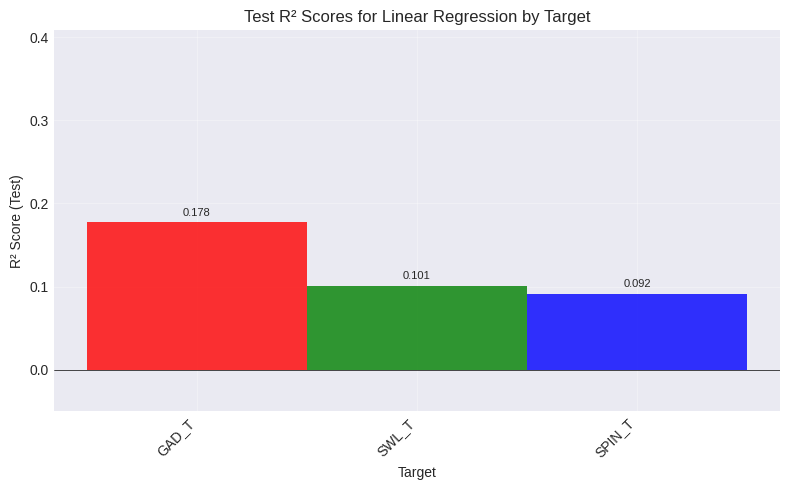

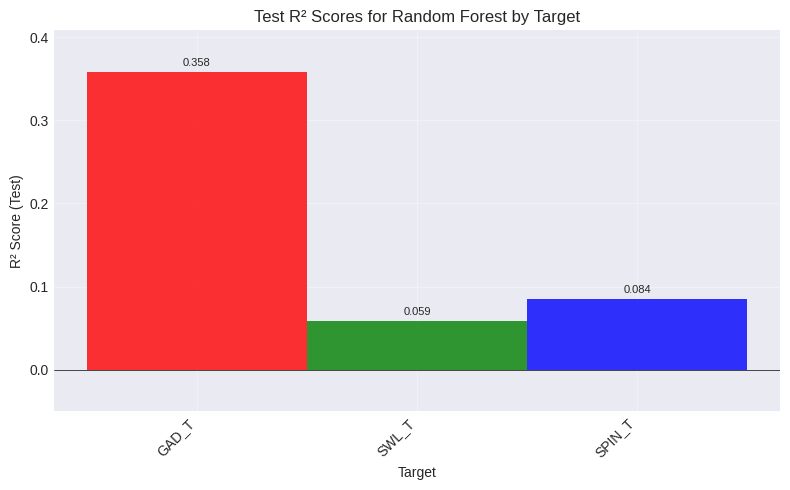

In [24]:
# Call the plot_r2 function with the 'all_results' dictionary to generate the R² plots.
r2_df_separate = plot_r2(all_results)

From our results  we see that Random Forest is significantly more accurate than Linear regression for predicting GAD_T whereas Linear regression actually beats Random Forest at the other 2 predictions but now by a large margin. We can also visualise the Mean Squared Error and Mean Absolute error, for our data set we'll stick to measuring the Mean Absolute Error as we do not have large data ranges due to the style of the questions the gamers were asked.

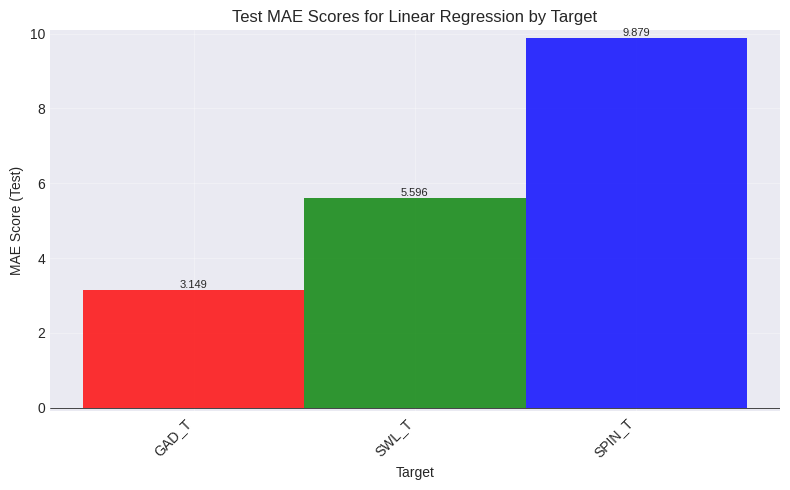

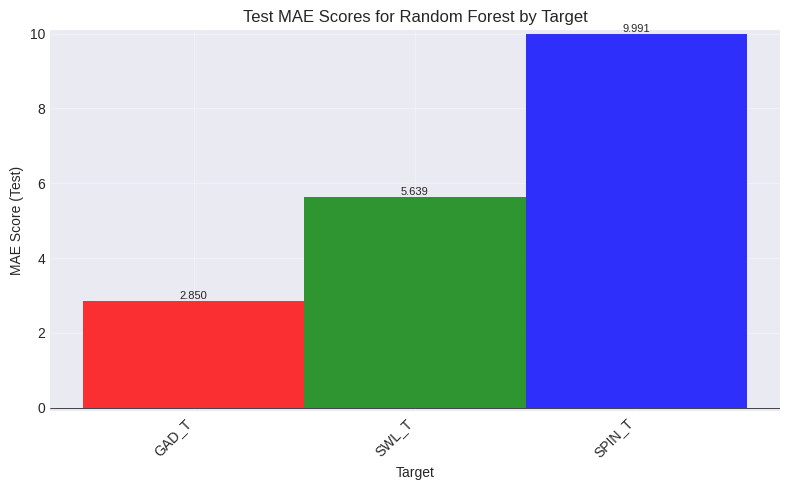

In [26]:
# Use the MAE plotting function to visualize Mean Absolute Error scores.
# This will generate separate bar charts for each model, showing MAE for each target variable.
mae_df_separate = plot_mae(all_results)


This plot gives us a much better picture to how accurate our ML models were, and they weren't very accurate at all. But these errors provide us a reason to why the accuracies of each target were so different. GAD has a smaller highest possible total so there was less room for error, SWL had a higher possible total and therefore performed worse and SPIN was even higher which led to a much bigger error score. This shows us that our ML models were pretty much just randomly guessing.

This leaves us wondering if a neural network approach could be more effective, in the next folder 'Q2' we will explore how a neural network would perform when trying to predict the same targets.